# **Part 1** 



data gathering

In [ ]:
# Install the required packages
! pip install beautifulsoup4
! pip install yfinance
! pip install pandas-ta
! pip install numpy as np
! pip install scikit-learn
! pip3 install backtesting

from bs4 import BeautifulSoup as bs 
import matplotlib.pyplot as plt
import requests
import yfinance as yf
import pandas as pd
import pandas_ta as ta
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



Get Stocks daily OCHLV data

In [2]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

tickers = []
industeries = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)
    industery = row.findAll('td')[3].text
    industeries.append(industery)
all_stocks = [x.replace('\n','') for x in tickers] # remove the new line character
all_industeries = [x.replace('\n','') for x in industeries] # remove the new line character



Download data from yfinance

In [ ]:
all_df = pd.DataFrame()
start_date = '2020-01-01'
end_date = '2023-01-01'
fname_string = 'all_stocks_' + start_date + '_' + end_date + '.csv'


for tkr in all_stocks:
  single_stock_pd = yf.download(tickers=tkr, start=start_date, end=end_date,auto_adjust=True)
  single_stock_pd['stock'] = tkr
  all_df = all_df.append(single_stock_pd)

all_df.to_csv(fname_string)

Calculate Features & Target values for all stocks

In [4]:
all_df = pd.read_csv(fname_string)
all_df['dt'] = pd.to_datetime(all_df['Date'])
all_df['t0'] = (all_df['dt'] - all_df['dt'].min()).dt.days.astype(float)


def get_features_df(start_train_features_day):
  # Split the data to segments (6 months features, 3 months labelling)
  FEATURES_SIZE = 180 
  LABELLING_SIZE = 90
  end_train_features_day = start_train_features_day + FEATURES_SIZE
  start_train_labelling_day = end_train_features_day + 1 
  end_train_labelling_day = start_train_labelling_day + LABELLING_SIZE
  features_df = all_df[(all_df['t0'] >= start_train_features_day)&(all_df['t0'] < end_train_features_day)]
  labelling_df = all_df[(all_df['t0'] >= start_train_labelling_day)&(all_df['t0'] < end_train_labelling_day)]

  #week df
  features_df.loc[:,'week_index'] = (features_df['t0'] / 7).astype(int)
  weekly_features_df = features_df.groupby(['stock','week_index']).apply(calculate_returns).reset_index()

  #month df
  features_df.loc[:,'month_index'] = (features_df['t0'] / 30).astype(int)
  monthly_features_df = features_df.groupby(['stock','month_index']).apply(calculate_returns).reset_index()

  return features_df, labelling_df

def calculate_returns(x):
  return 100*(x.iloc[-1]['Close'] - x.iloc[0]['Open'])/x.iloc[0]['Open']


Price movement threshold - labelling time

In [5]:
def add_label_to_labelling_df(labelling_df):
  lbl_returns = labelling_df.groupby('stock').apply(lambda x: calculate_returns(x)).reset_index()
  lbl_returns.columns = ['stock', 'pct_price_movement']
  threshold = lbl_returns['pct_price_movement'].median()
  lbl_returns['label'] = (lbl_returns['pct_price_movement']>threshold).astype(int)
  return lbl_returns.set_index('stock')

# 1.1 + 1.2

picking out 1 feature (rsi of the stock's last week) and caculating its threshold

In [ ]:
one_ft_df, one_lb_df = get_features_df(0)
#החישוב ממוצע RSI של שבוע אחרון
one_rsis = one_ft_df.groupby('stock')['Close'].apply(ta.rsi)
one_ft_df['rsi'] = one_rsis
rsi_df = one_ft_df.loc[one_ft_df['week_index'] == 25].groupby('stock')['rsi'].mean().reset_index(name='rsi')

rsi_df.columns = ['stock', 'rsi']
threshold = rsi_df['rsi'].median()
# threshold = 35
rsi_df['label'] = (rsi_df['rsi'] < threshold).astype(int)
lbl_returns = add_label_to_labelling_df(one_lb_df)
regression_df = pd.merge(lbl_returns, rsi_df, on='stock')
rsi_df.set_index('stock', inplace=True)
rsi_df['label'].value_counts()

corrolation between our feature to the stock's value

In [7]:
from scipy.stats import pearsonr
# Merge the two dataframes on stock symbols
#lbl_returns = add_label_to_labelling_df(one_lb_df)
#regression_df = pd.merge(lbl_returns, rsi_df, on='stock')

x = regression_df['pct_price_movement']
y = regression_df['rsi']
r, p = pearsonr(x, y)
print("Pearson correlation coefficient: ", r)
print("p-value: ", p)

Pearson correlation coefficient:  0.12654840544946908
p-value:  0.004679221269153811


regression between our feature to the stock's value

In [8]:
import numpy as np
from sklearn.linear_model import LinearRegression

x = np.array(regression_df['rsi']).reshape(-1,1)
y = np.array(regression_df['pct_price_movement'])
reg = LinearRegression().fit(x, y)
rsi_predicted = reg.predict(x)
regression_df['rsi_predicted'] = rsi_predicted
print("Intercept: ", reg.intercept_)
print("Coefficient : ",reg.coef_)

Intercept:  -5.913630253284162
Coefficient :  [0.27523639]


Showing the corrolation between the choosen feature and the yield of the stocks in the next 3 monthes. 

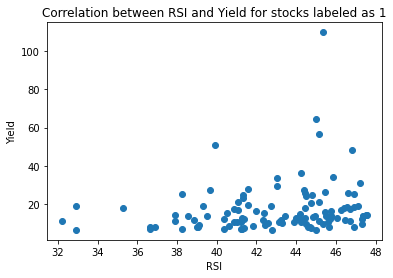

In [9]:

# Extract stocks labeled as 1 for both RSI and yield
rsi_lbl_1 = rsi_df[rsi_df['label'] == 1]
yield_lbl_1 = lbl_returns[lbl_returns['label'] == 1]

# Merge the two dataframes on stock symbols
merged_df = pd.merge(rsi_lbl_1, yield_lbl_1, on='stock')

# Create a scatter plot
plt.scatter(merged_df['rsi'], merged_df['pct_price_movement'])
plt.xlabel('RSI')
plt.ylabel('Yield')
plt.title('Correlation between RSI and Yield for stocks labeled as 1')
plt.show()
#This code will extract the stocks with RSI labeled as 1 and yield labeled as 1, merge them based on their stock symbols, and create a scatter plot with RSI on the x-axis and yield on the y-axis. This will show the correlation between the two variables for stocks labeled as 1 in both RSI and yield.





showing the differences between the stocks labled 1 and 0, by our feature

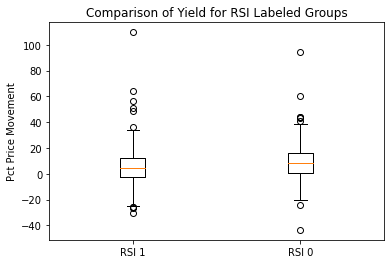

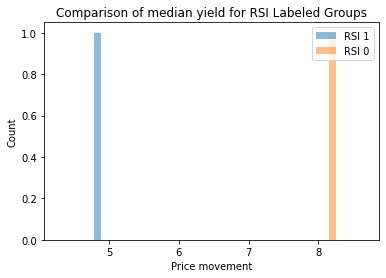

20% Percentile Yield Difference: -2.41
Skewness of Yield Difference: 0.74
Kurtosis of Yield Difference: 4.30
Yield Difference: -347.13%
Mean Difference: -3.47
Median Difference: -3.36


In [10]:
from scipy.stats import skew
from scipy.stats import kurtosis
# Merge dataframes by stock symbol
merged_df_2 = pd.merge(rsi_df, lbl_returns, on='stock')

def differences_0_1(merged_df_2):
  # Calculate difference in yield between RSI labeled groups
  group_1_yield = merged_df_2[merged_df_2['label_x'] == 1]['pct_price_movement']
  group_0_yield = merged_df_2[merged_df_2['label_x'] == 0]['pct_price_movement']
  yield_diff = group_1_yield.mean() - group_0_yield.mean()

  # Calculate difference in mean between RSI labeled groups
  group_1_mean = merged_df_2[merged_df_2['label_x'] == 1]['pct_price_movement'].mean()
  group_0_mean = merged_df_2[merged_df_2['label_x'] == 0]['pct_price_movement'].mean()
  mean_diff = group_1_mean - group_0_mean

  # Calculate difference in median between RSI labeled groups
  group_1_median = merged_df_2[merged_df_2['label_x'] == 1]['pct_price_movement'].median()
  group_0_median = merged_df_2[merged_df_2['label_x'] == 0]['pct_price_movement'].median()
  median_diff = group_1_median - group_0_median

  # Plot boxplots of yield for the two groups
  plt.boxplot([group_1_yield, group_0_yield], labels=['RSI 1', 'RSI 0'])
  plt.ylabel('Pct Price Movement')
  plt.title('Comparison of Yield for RSI Labeled Groups')
  plt.show()

  # Plot histograms of price for the two groups
  plt.hist(group_1_median, alpha=0.5, label='RSI 1')
  plt.hist(group_0_median, alpha=0.5, label='RSI 0')
  plt.xlabel('Price movement')
  plt.ylabel('Count')
  plt.legend(loc='upper right')
  plt.title('Comparison of median yield for RSI Labeled Groups')
  plt.show()

  # Calculate 20% percentile value for both groups
  group_1_20pct = np.percentile(group_1_yield, 20)
  group_0_20pct = np.percentile(group_0_yield, 20)
  pct_diff = group_1_20pct - group_0_20pct

  # Calculate skewness for both groups
  group_1_skew = skew(group_1_yield)
  group_0_skew = skew(group_0_yield)
  skew_diff = group_1_skew - group_0_skew

  # Calculate kurtosis for both groups
  group_1_kurtosis = kurtosis(group_1_yield)
  group_0_kurtosis = kurtosis(group_0_yield)
  kurtosis_diff = group_1_kurtosis - group_0_kurtosis

  # Print out the results
  print(f'20% Percentile Yield Difference: {pct_diff:.2f}')
  print(f'Skewness of Yield Difference: {skew_diff:.2f}')
  print(f'Kurtosis of Yield Difference: {kurtosis_diff:.2f}')
  print(f'Yield Difference: {yield_diff:.2%}')
  print(f'Mean Difference: {mean_diff:.2f}')
  print(f'Median Difference: {median_diff:.2f}')

differences_0_1(merged_df_2)

confusion matrix, precision, recall


      True positive: 109,
      True negative: 109,
      False positive: 140,
      False negative: 140
    
Precision: 0.43775100401606426
Recall: 0.43775100401606426


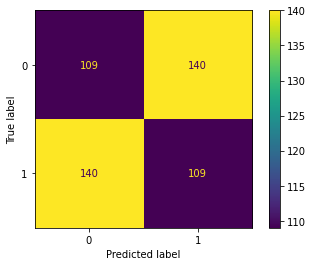

In [11]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
def show_differences(rsi_df):
  # Define the true labels and predicted labels based on the threshold
  true_labels = lbl_returns['label']
  predicted_labels = (rsi_df['rsi'] < threshold).astype(int)

  # Calculate the confusion matrix, precision, and recall
  true_positive = len(rsi_df[(rsi_df['label'] == lbl_returns['label'])&(rsi_df['label']==True)])
  true_negative = len(rsi_df[(rsi_df['label'] == lbl_returns['label'])&(rsi_df['label']==False)])
  false_positive = len(rsi_df[(rsi_df['label'] != lbl_returns['label'])&(rsi_df['label']==True)])
  false_negative = len(rsi_df[(rsi_df['label'] != lbl_returns['label'])&(rsi_df['label']==False)])
  print(
    f'''
      True positive: {true_positive},
      True negative: {true_negative},
      False positive: {false_positive},
      False negative: {false_negative}
    ''')
  matrix = confusion_matrix(lbl_returns['label'], rsi_df['label'])
  disp_1 = ConfusionMatrixDisplay(matrix, display_labels=[0,1])
  disp_1.plot()
  precision = precision_score(true_labels, predicted_labels)
  recall = recall_score(true_labels, predicted_labels)

  print('Precision:', precision)
  print('Recall:', recall)
show_differences(rsi_df)

# 1.3

finding a new threshold from the predicted column

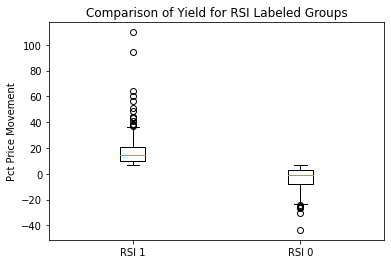

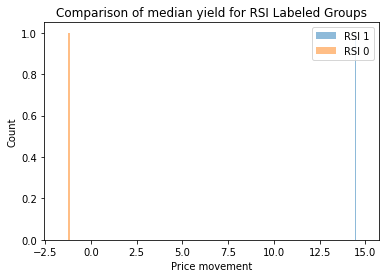

20% Percentile Yield Difference: 18.95
Skewness of Yield Difference: 4.80
Kurtosis of Yield Difference: 15.00
Yield Difference: 2079.66%
Mean Difference: 20.80
Median Difference: 15.64

      True positive: 109,
      True negative: 109,
      False positive: 140,
      False negative: 140
    
Precision: 0.43775100401606426
Recall: 0.43775100401606426


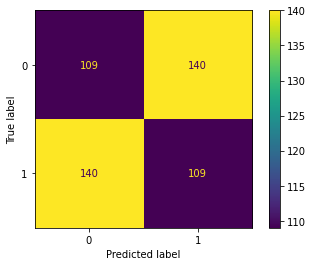

In [12]:
regression_df_labeled = regression_df.copy()
regression_df_labeled.columns = ['stock',	'pct_price_movement',	'label_x',	'rsi',	'label_y', 'rsi_predicted']
threshold = regression_df_labeled['rsi_predicted'].median()
regression_df_labeled['label'] = (regression_df_labeled['rsi_predicted'] < threshold).astype(int)
regression_df_labeled.set_index('stock', inplace=True)
regression_df_labeled.drop(['rsi'], axis=1, inplace=True)
regression_df_labeled.columns = ['pct_price_movement',	'label_x', 'label_y', 'rsi', 'label']
differences_0_1(regression_df_labeled)
show_differences(regression_df_labeled)


# 1.4
we decided to use the Relative Strength Index (RSI) of a stock in the last week of the 'feature period' as an indicator for investment in the near future, based on the belief that RSI is a good indication for oversold stocks. When a stock's RSI is above 70, it is considered overbought, and it is not advisable to buy it. Conversely, when the RSI is below 30, it is considered oversold, and it is a good time to buy. We also conducted a feature importance test and found that the RSI feature had a high score.

However, we were surprised to see that the results were opposite to what we had expected in the next 3 months. Despite setting a threshold such that if a stock's RSI is below the median, it is labeled '1', and '0' otherwise, this feature did not predict future stock yield accurately.

On the contrary, when we ran a linear regression between our RSI column and the future profits column, the prediction was much better than our 'single threshold labeling' system. Its predictions were very accurate. 

# ***part 2***

# 2.1

create a data frame for all features

In [13]:
def calculate_featurs(features_df):
  monthly_features_df = features_df.groupby(['stock','month_index']).apply(calculate_returns).reset_index()
  weekly_features_df = features_df.groupby(['stock','week_index']).apply(calculate_returns).reset_index()
  worst_monthly_return = monthly_features_df.groupby('stock').min().reset_index()
  best_monthly_return = monthly_features_df.groupby('stock').max().reset_index()

  #תשואה כוללת עבור כל מניה
  features_yield = features_df.groupby('stock').apply(lambda x: calculate_returns(x)).reset_index()

  #הוספה שלנו- תשואה יומית עבור כל מניה
  # features_df['yield'] = 100*(features_df['Close'] - features_df['Open'])/features_df['Open']
  features_df.loc[:, 'yield'] = 100*(features_df['Close'] - features_df['Open'])/features_df['Open']

  #חישוב ממוצע של כל חודש עבור כל מניה ולעשות ממוצע שלהם

  mean_month = monthly_features_df.groupby('stock')[0].mean()

  #חישוב ממוצע של כל שבוע עבור כל מניה ולעשות ממוצע שלהם
  mean_week = weekly_features_df.groupby('stock')[0].mean()

  #חישוב ממוצע של חודש אחרון
  last_month = monthly_features_df['month_index'].max()
  last_month_yield = monthly_features_df[monthly_features_df['month_index'] == last_month].drop(['month_index'], axis = 1)

  # #החישוב ממוצע RSI של שבוע אחרון
  # rsis = features_df.groupby('stock')['Close'].apply(ta.rsi)
  # features_df['rsi'] = rsis
  # features_df.loc[:, 'rsi'] = rsis
  # last_week = weekly_features_df['week_index'].max()
  # last_week_rsi = features_df.loc[features_df['week_index'] == last_week].groupby('stock')['rsi'].mean()

  #מחשב את ממוצע הווליום של כל מניה לפי החודש הטוב ביותר שלה
  best_yield_month = features_df.groupby(['stock', 'month_index'])['yield'].mean().reset_index().sort_values(by='yield', ascending=False).groupby('stock').first()
  best_yield_month = pd.merge(best_yield_month, features_df[['stock', 'month_index']], on=['stock', 'month_index'])
  mean_volume_best_month = features_df[features_df['month_index'].isin(best_yield_month['month_index'])].groupby('stock')['Volume'].mean().reset_index()
  mean_volume_best_month = mean_volume_best_month.rename(columns={'Volume': 'mean_volume_best_month'})

  #מחשב את ממוצע הווליום בחודש הגרוע ביותר של כל מניה
  worst_month_df = features_df.loc[features_df['yield'] == features_df.groupby('stock')['yield'].transform(min)]
  worst_month_mean_volume = worst_month_df.groupby('stock')['Volume'].mean().reset_index()


  ft_df = best_monthly_return[['stock',0]]
  ft_df['worst'] = worst_monthly_return[0]
  
  #ממוצע הווליום 
  mean_volume = features_df.groupby('stock')['Volume'].mean().reset_index()

  #merging all data frames

  std_yield = features_df.groupby('stock')['yield'].std()
  ft_df = pd.merge(ft_df, std_yield, on='stock')
  ft_df = pd.merge(ft_df,  mean_month, on='stock')
  ft_df = pd.merge(ft_df,  mean_week, on='stock')
  ft_df = pd.merge(ft_df, last_month_yield, on='stock', suffixes=('_ft', '_lmy'))
  # ft_df = pd.merge(ft_df, last_week_rsi, on='stock')
  ft_df = pd.merge(ft_df, mean_volume_best_month, on='stock')
  ft_df = pd.merge(ft_df, worst_month_mean_volume, on='stock')
  ft_df = pd.merge(ft_df, features_yield, on='stock')
  ft_df = pd.merge(ft_df, mean_volume, on='stock')

  ft_df.columns = ['stock', 'best_month', 'worst_month', 'std_yield', 'mean_month',
                    'mean_week', 'last_month_yield', 'mean_volume_best','mean_volume_worst', 'total_yield', 'volume_mean']
  return ft_df.set_index('stock')

Checking feature importances

In [14]:
train_df_important, target_df_important = get_features_df(0)
label_df_impotrant = add_label_to_labelling_df(target_df_important)
train_df_important2 = calculate_featurs(train_df_important)

monthly_features_df = train_df_important.groupby(['stock','month_index']).apply(calculate_returns).reset_index()
weekly_features_df = train_df_important.groupby(['stock','week_index']).apply(calculate_returns).reset_index()
#החישוב ממוצע RSI של שבוע אחרון
rsis = train_df_important.groupby('stock')['Close'].apply(ta.rsi)
# train_df_important['rsi'] = rsis
train_df_important.loc[:, 'rsi'] = rsis
last_week = weekly_features_df['week_index'].max()
last_week_rsi = train_df_important.loc[train_df_important['week_index'] == last_week].groupby('stock')['rsi'].mean()
train_df_important2 = pd.merge(train_df_important2, last_week_rsi, on='stock')
train_df_important2.columns = ['best_month', 'worst_month', 'std_yield', 'mean_month',
                    'mean_week', 'last_month_yield', 'mean_volume_best','mean_volume_worst', 'total_yield', 'volume_mean', 'last_week_rsi']

train_df_important2 = pd.merge(train_df_important2, label_df_impotrant, on ='stock')

# Training a Random Forest ML model to predict if the stock return will be above the median return in the labelling period
# based on best and worst month in the feature period 
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(train_df_important2[['best_month','worst_month','std_yield','mean_month','mean_week',
                  'last_month_yield', 'mean_volume_best','mean_volume_worst','total_yield','volume_mean', 'last_week_rsi']], train_df_important2['label'])

def get_feature_importances(clf, feature_names):
    importances = clf.feature_importances_
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    return feature_importances


feature_names = ['best_month', 'worst_month', 'std_yield', 'mean_month', 'mean_week',
                 'last_month_yield', 'mean_volume_best', 'mean_volume_worst', 'total_yield', 'volume_mean', 'last_week_rsi']

feature_importances = get_feature_importances(clf, feature_names)

print(feature_importances)

<ipython-input-4-6d262d2e1a06>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:,'week_index'] = (features_df['t0'] / 7).astype(int)
<ipython-input-4-6d262d2e1a06>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:,'month_index'] = (features_df['t0'] / 30).astype(int)
<ipython-input-13-eec1d457eb48>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

[('mean_week', 0.17), ('std_yield', 0.15), ('last_week_rsi', 0.12), ('mean_month', 0.11), ('last_month_yield', 0.09), ('total_yield', 0.09), ('best_month', 0.07), ('worst_month', 0.06), ('mean_volume_best', 0.05), ('mean_volume_worst', 0.05), ('volume_mean', 0.05)]


# training the model

In [ ]:
train_df, target_df = get_features_df(0)
label_df = add_label_to_labelling_df(target_df)
train_df = calculate_featurs(train_df)
train_df = pd.merge(train_df, label_df, on ='stock')
# Training a Random Forest ML model to predict if the stock return will be above the median return in the labelling period
# based on best and worst month in the feature period 
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(train_df[['best_month','worst_month','std_yield','mean_month','mean_week',
                  'last_month_yield', 'mean_volume_best','mean_volume_worst','total_yield','volume_mean']], train_df['label'])


# testing the model 12 times

In [16]:
def test_model(start_test_day):
  features_df, labelling_df = get_features_df(start_test_day)
  actual_df = add_label_to_labelling_df(labelling_df)
  test_df = calculate_featurs(features_df)
  test_df['predicted_y'] = clf.predict(test_df[['best_month','worst_month', 'std_yield','mean_month','mean_week',
                                                'last_month_yield', 'mean_volume_best','mean_volume_worst', 'total_yield', 'volume_mean']])
  test_df = pd.merge(test_df, actual_df, on='stock')

  true_positive = len(test_df[(test_df['predicted_y'] == test_df['label'])&(test_df['predicted_y']==True)])
  true_negative = len(test_df[(test_df['predicted_y'] == test_df['label'])&(test_df['predicted_y']==False)])
  false_positive = len(test_df[(test_df['predicted_y'] != test_df['label'])&(test_df['predicted_y']==True)])
  false_negative = len(test_df[(test_df['predicted_y'] != test_df['label'])&(test_df['predicted_y']==False)])
  print(
  f'''
  Train results:
    True positive: {true_positive},
    True negative: {true_negative},
    False positive: {false_positive},
    False negative: {false_negative}
  ''')
  matrix = confusion_matrix(test_df['label'], test_df['predicted_y'])
  disp_1 = ConfusionMatrixDisplay(matrix, display_labels=[0,1])
  disp_1.plot()

month :  1


<ipython-input-4-6d262d2e1a06>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:,'week_index'] = (features_df['t0'] / 7).astype(int)
<ipython-input-4-6d262d2e1a06>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:,'month_index'] = (features_df['t0'] / 30).astype(int)
<ipython-input-13-eec1d457eb48>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 


  Train results:
    True positive: 227,
    True negative: 16,
    False positive: 233,
    False negative: 22
  
month :  2


<ipython-input-4-6d262d2e1a06>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:,'month_index'] = (features_df['t0'] / 30).astype(int)
<ipython-input-13-eec1d457eb48>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:, 'yield'] = 100*(features_df['Close'] - features_df['Open'])/features_df['Open']
<ipython-input-4-6d262d2e1a06>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins


  Train results:
    True positive: 235,
    True negative: 7,
    False positive: 242,
    False negative: 14
  
month :  3


<ipython-input-4-6d262d2e1a06>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:,'month_index'] = (features_df['t0'] / 30).astype(int)
<ipython-input-13-eec1d457eb48>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:, 'yield'] = 100*(features_df['Close'] - features_df['Open'])/features_df['Open']
<ipython-input-4-6d262d2e1a06>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins


  Train results:
    True positive: 229,
    True negative: 15,
    False positive: 235,
    False negative: 20
  
month :  4


<ipython-input-4-6d262d2e1a06>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:,'month_index'] = (features_df['t0'] / 30).astype(int)
<ipython-input-13-eec1d457eb48>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:, 'yield'] = 100*(features_df['Close'] - features_df['Open'])/features_df['Open']
<ipython-input-4-6d262d2e1a06>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins


  Train results:
    True positive: 232,
    True negative: 23,
    False positive: 227,
    False negative: 17
  
month :  5


<ipython-input-4-6d262d2e1a06>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:,'month_index'] = (features_df['t0'] / 30).astype(int)
<ipython-input-13-eec1d457eb48>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:, 'yield'] = 100*(features_df['Close'] - features_df['Open'])/features_df['Open']
<ipython-input-4-6d262d2e1a06>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins


  Train results:
    True positive: 229,
    True negative: 23,
    False positive: 227,
    False negative: 20
  
month :  6


<ipython-input-4-6d262d2e1a06>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:,'month_index'] = (features_df['t0'] / 30).astype(int)
<ipython-input-13-eec1d457eb48>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:, 'yield'] = 100*(features_df['Close'] - features_df['Open'])/features_df['Open']



  Train results:
    True positive: 232,
    True negative: 11,
    False positive: 239,
    False negative: 17
  
month :  7


<ipython-input-4-6d262d2e1a06>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:,'week_index'] = (features_df['t0'] / 7).astype(int)
<ipython-input-4-6d262d2e1a06>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:,'month_index'] = (features_df['t0'] / 30).astype(int)
<ipython-input-13-eec1d457eb48>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 


  Train results:
    True positive: 234,
    True negative: 16,
    False positive: 234,
    False negative: 15
  
month :  8


<ipython-input-4-6d262d2e1a06>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:,'month_index'] = (features_df['t0'] / 30).astype(int)
<ipython-input-13-eec1d457eb48>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:, 'yield'] = 100*(features_df['Close'] - features_df['Open'])/features_df['Open']
<ipython-input-4-6d262d2e1a06>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins


  Train results:
    True positive: 241,
    True negative: 21,
    False positive: 229,
    False negative: 8
  
month :  9


<ipython-input-4-6d262d2e1a06>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:,'month_index'] = (features_df['t0'] / 30).astype(int)
<ipython-input-13-eec1d457eb48>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:, 'yield'] = 100*(features_df['Close'] - features_df['Open'])/features_df['Open']
<ipython-input-4-6d262d2e1a06>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins


  Train results:
    True positive: 230,
    True negative: 10,
    False positive: 240,
    False negative: 19
  
month :  10


<ipython-input-4-6d262d2e1a06>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:,'month_index'] = (features_df['t0'] / 30).astype(int)
<ipython-input-13-eec1d457eb48>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:, 'yield'] = 100*(features_df['Close'] - features_df['Open'])/features_df['Open']
<ipython-input-4-6d262d2e1a06>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins


  Train results:
    True positive: 235,
    True negative: 18,
    False positive: 232,
    False negative: 14
  
month :  11


<ipython-input-4-6d262d2e1a06>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:,'month_index'] = (features_df['t0'] / 30).astype(int)
<ipython-input-13-eec1d457eb48>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:, 'yield'] = 100*(features_df['Close'] - features_df['Open'])/features_df['Open']
<ipython-input-4-6d262d2e1a06>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins


  Train results:
    True positive: 236,
    True negative: 32,
    False positive: 218,
    False negative: 14
  
month :  12


<ipython-input-4-6d262d2e1a06>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:,'month_index'] = (features_df['t0'] / 30).astype(int)
<ipython-input-13-eec1d457eb48>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df.loc[:, 'yield'] = 100*(features_df['Close'] - features_df['Open'])/features_df['Open']



  Train results:
    True positive: 229,
    True negative: 34,
    False positive: 216,
    False negative: 21
  


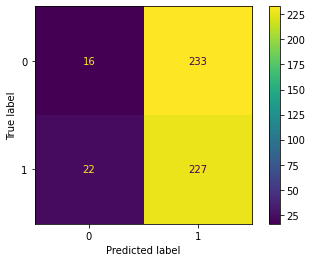

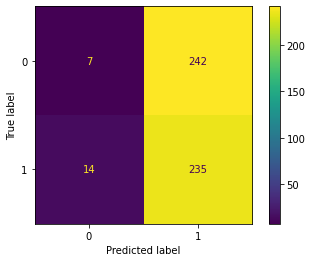

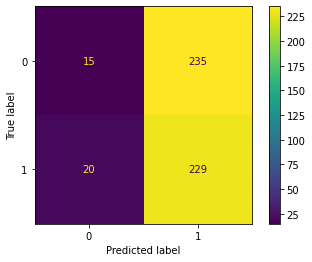

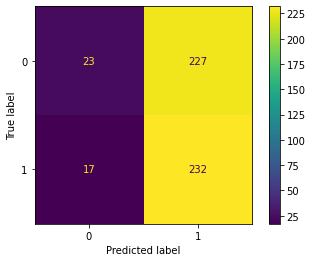

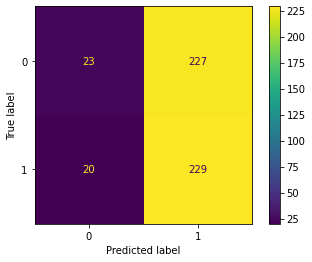

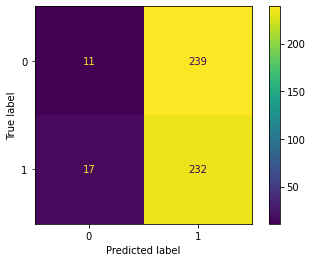

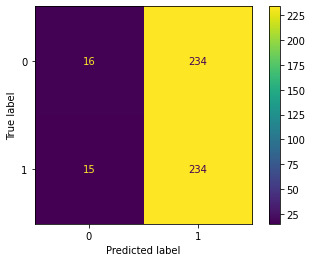

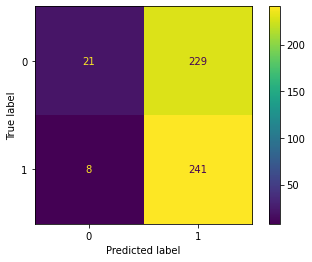

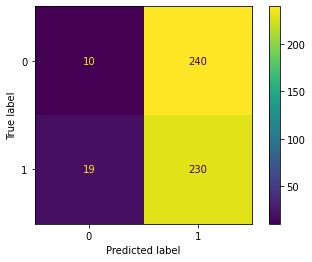

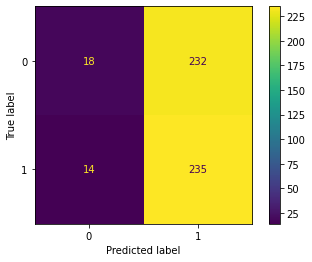

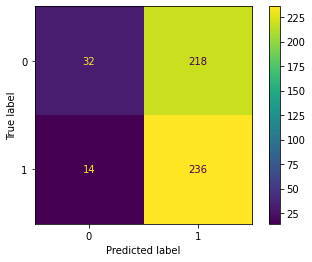

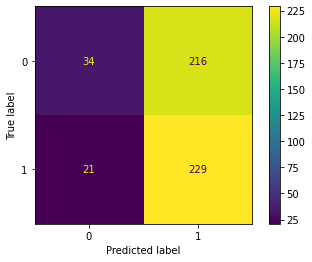

In [17]:
months = [271, 301, 331, 361, 391, 421, 451, 481, 511, 541, 571, 601]
i = 1
for month in months:
  print("month : ", i)
  i = i + 1
  test_model(month)





Training the modle on 9 month before 2022_06_01

we chose to train the model as close as we can to the point when we invest our money in stocks. The reason is because the closer the 'Train' period is to the invesment time, the data it recieved  will be more relevent to predicting rises and falls of stocks.

In [ ]:
train_df_2, target_df_2 = get_features_df(424)
label_df_2 = add_label_to_labelling_df(target_df_2)
train_df_2 = calculate_featurs(train_df_2)
train_df_2 = pd.merge(train_df_2, label_df_2, on ='stock')
# Training a Random Forest ML model to predict if the stock return will be above the median return in the labelling period
# based on best and worst month in the feature period 
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(train_df_2[['best_month','worst_month','std_yield','mean_month','mean_week',
                  'last_month_yield', 'mean_volume_best','mean_volume_worst','total_yield', 'volume_mean']], train_df_2['label'])

Extract the features from 01-01-2022 to choose our stocks for the protfolio. 

After training our predictive model and evaluating its performance, we want to use it to make investment decisions. To do this, we need to select a set of stocks to invest in.

We've decided to use the predicted values from our model to identify stocks that are likely to yield high returns. Specifically, we're selecting stocks where the predicted value is 1, indicating that our model believes they will outperform the market in the near future.

However, we also want to be mindful of risk, so we've decided to add two additional conditions to our selection process. First, we're only considering stocks with a standard yield below the median. This helps us avoid stocks that may be too volatile or risky for our investment strategy. Second, we're only selecting stocks where the last month's yield is above the median. This allows us to trade in the same direction as the recent movement of the market, which may help reduce risk and improve returns.

In [ ]:
features_df_protfolio = all_df[(all_df['t0'] >= 729)&(all_df['t0'] < 880)]
#week df
features_df_protfolio['week_index'] = (features_df_protfolio['t0'] / 7).astype(int)

#month df
features_df_protfolio['month_index'] = (features_df_protfolio['t0'] / 30).astype(int)
features_df_protfolio
features_df_protfolio = calculate_featurs(features_df_protfolio)
features_df_protfolio['predicted_y'] = clf.predict(features_df_protfolio[['best_month','worst_month', 'std_yield','mean_month','mean_week',
                                                'last_month_yield','mean_volume_best','mean_volume_worst', 'total_yield', 'volume_mean']])

In [20]:
features_df_protfolio
features_df_protfolio['predicted_y'].value_counts()
median_yield = features_df_protfolio.loc[features_df_protfolio['predicted_y'] == 1, 'std_yield'].median()
stocks_list = features_df_protfolio.loc[(features_df_protfolio['predicted_y'] == 1) & (features_df_protfolio['std_yield'] < median_yield) & (features_df_protfolio['last_month_yield'] > 0)].index.tolist()
len(stocks_list)

79

In [21]:
features_df_protfolio_df = all_df[all_df['stock'].isin(stocks_list)]
features_df_protfolio_2 = features_df_protfolio_df['Close'].pct_change()

Our stocks data
Sharpe Ratio

In [22]:
mean_return = features_df_protfolio_2.mean()
Rf = 0.0 # Risk free interest
std_return = features_df_protfolio_2.std()
portfolio_sharpe = (mean_return - Rf) / std_return
print(f'Sharp Ratio: {portfolio_sharpe}')

Sharp Ratio: 0.017018030544447962


Volatility

In [23]:
portfolio_volatility = features_df_protfolio_2.std()*252**0.5
print(f'Volatility: {portfolio_volatility}')

Volatility: 0.8221801418658181


Max Draw-down

In [24]:
total_returns = (1 + features_df_protfolio_2).cumprod() - 1
portfolio_max_draw_down = (total_returns.cummax() - total_returns).max()
print(f'Max Draw-down: {portfolio_max_draw_down}')

Max Draw-down: 4.753057464425686


S&P500 Data

In [25]:
all_df[(all_df['t0'] >= 729)&(all_df['t0'] < 880)]
SAP500 = all_df[(all_df['t0'] >= 729)&(all_df['t0'] < 880)]['Close'].pct_change()
print("S&P500")
# Sharpe Ratio
mean_return = SAP500.mean()
Rf = 0.0 # Risk free interest
std_return = SAP500.std()
SAP500_sharpe = (mean_return - Rf) / std_return
print(f'Sharp Ratio: {SAP500_sharpe}')

# Volatility
SAP500_volatility = SAP500.std()*252**0.5
print(f'Volatility: {SAP500_volatility}')

#Max Draw-down
total_returns = (1 + SAP500).cumprod() - 1
# total_returns = total_returns.drop('CEG')
# total_returns.replace([np.inf, -np.inf], np.nan, inplace=True)
SAP500_max_draw_down = (total_returns.cummax() - total_returns).max()
print(f'Max Draw-down: {SAP500_max_draw_down}')

S&P500
Sharp Ratio: 0.03376360086790718
Volatility: 5.487337319853052
Max Draw-down: 35.078808039650305


The portfolio's Sharpe ratio is lower than that of the S&P 500, indicating that the portfolio is generating a lower return per unit of risk taken on. This could mean that the portfolio is not performing as well as the market overall.

The portfolio's volatility is significantly lower than that of the S&P 500, indicating that the portfolio is less volatile than the market overall. This could mean that the portfolio is more stable and may be a better choice for investors looking for a less risky investment.

The portfolio's maximum draw-down is also significantly lower than that of the S&P 500, indicating that the portfolio has experienced smaller losses in the past. This could mean that the portfolio is better protected during market downturns and may be a good choice for investors who are more risk-averse.

Overall, while the portfolio may be generating lower returns than the S&P 500, it may be a good choice for investors who are looking for a less volatile and less risky investment option.

In [26]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA
from statistics import mean, stdev

# Using Backtesting.py can be installed with "pip3 install backtesting"

class SmaCross(Strategy):
    n1 = 10
    n2 = 20

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()
            
def calculate_portfolio_stats(all_data, portfolio_stocks):
    '''
        all_data: pd.Dataframe, needs to include all your required stocks OHLCV data.
        portfolio_stocks: List[str], list of your required portfolio stock tickers for an example: ['AAPL','TSLA'].
        must be consistentr with the stocks column uin your all_data df
    '''
    assert len(portfolio_stocks) > 1, 'portfolio must include more than one stock'
    returns = []
    sharpes = []
    for stock in portfolio_stocks:
        if stock == 'A': continue
        stock_data = all_data[all_data['stock'] == stock][['Open', 'High', 'Low', 'Close', 'Volume']]
        bt = Backtest(stock_data, SmaCross,
                    cash=10000, commission=.002,
                    exclusive_orders=True)
        output = bt.run()
        sharpes.append(output.loc['Sharpe Ratio'])
        returns.append(output.loc['Return [%]'])
    mean_returns = mean(returns)
    returns_std = stdev(returns)
    mean_sharpes = mean(sharpes)
    sharpes_std = stdev(sharpes)
    max_yield = max(returns)
    max_yield_stock = portfolio_stocks[returns.index(max_yield)]
    return mean_returns, returns_std, mean_sharpes, sharpes_std, max_yield_stock


/usr/local/lib/python3.9/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Part 3

In [27]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG


class SmaCross(Strategy):
    n1 = 10
    n2 = 20

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()


In [28]:
all_df.set_index('dt', inplace = True)

In [ ]:
all_df_3 = pd.DataFrame()
start_backtest_date = '2022-06-01'
end_backtest_date = '2022-09-01'
fname_string_backtest = 'all_stocks_' + start_backtest_date + '_' + end_backtest_date + '.csv'


for tkr in all_stocks:
  single_stock_pd = yf.download(tickers=tkr, start=start_backtest_date, end=end_backtest_date, auto_adjust=True)
  single_stock_pd['stock'] = tkr
  all_df_3 = all_df_3.append(single_stock_pd)

all_df_3.to_csv(fname_string_backtest)

In [30]:
all_df_3 = pd.read_csv(fname_string_backtest)
all_df_3['dt'] = pd.to_datetime(all_df_3['Date'])
# all_df_3 = pd.read_csv(fname_string_backtest, index_col='Date', parse_dates=True)
all_df_3.set_index('dt', inplace = True)

In [31]:
calculate_portfolio_stats(all_df_3, stocks_list)

(-3.1075219690326206,
 8.257365699863312,
 0.36444084819499567,
 0.717850751988826,
 'ADP')

Run the protfolio On all the stocks and show data on the best one

In [32]:
results = {}
for stock in stocks_list:
    bt = Backtest(all_df_3.loc[all_df_3['stock'] == stock], SmaCross, 
                  cash=10000, commission=.002, 
                  exclusive_orders=True)
    output = bt.run()
    results[stock] = output.loc['Return [%]']

best_stock = max(results, key=results.get)
print(f"The stock with the highest return is {best_stock} with a return of {results[best_stock]}%")
# bt.plot()
bt = Backtest(all_df_3.loc[all_df_3['stock'] == best_stock], SmaCross, 
                  cash=10000, commission=.002, 
                  exclusive_orders=True)
output = bt.run()
print(output)

The stock with the highest return is ADP with a return of 18.16423127016402%
Start                     2022-06-01 00:00:00
End                       2022-08-31 00:00:00
Duration                     91 days 00:00:00
Exposure Time [%]                     64.0625
Equity Final [$]                 11816.423127
Equity Peak [$]                  12420.381394
Return [%]                          18.164231
Buy & Hold Return [%]               11.969234
Return (Ann.) [%]                   92.936217
Volatility (Ann.) [%]               41.377116
Sharpe Ratio                         2.246078
Sortino Ratio                       10.296302
Calmar Ratio                        15.899927
Max. Drawdown [%]                   -5.845072
Avg. Drawdown [%]                   -1.480085
Max. Drawdown Duration       13 days 00:00:00
Avg. Drawdown Duration        5 days 00:00:00
# Trades                                    3
Win Rate [%]                            100.0
Best Trade [%]                      13.534114
Wor